In [7]:
# Standard library imports
import os
import warnings
from pathlib import Path
from typing import List, Union, Tuple

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from umap import UMAP

# Project imports
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

# Suppress warnings
warnings.filterwarnings('ignore')

# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3')

# Print the current working directory to confirm the change
print(f"Current working directory: {os.getcwd()}")

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_SRRM3


In [8]:
# Initialize cache
download_base = Path('./DATA/abc_atlas')
download_base.mkdir(parents=True, exist_ok=True)
abc_cache = AbcProjectCache.from_cache_dir(download_base)
abc_cache.load_latest_manifest()
abc_cache.current_manifest

'releases/20241115/manifest.json'

In [12]:
# Load and process metadata first
print("Loading metadata...")
cell_metadata = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='cell_metadata'
)

Loading metadata...


In [10]:
cell_metadata.head(5)

,cell_label,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,donor_label,donor_genotype,donor_sex,dataset_label,x,y,cluster_alias,abc_sample_id
0,GCGAGAAGTTAAGGGC-410_B05,GCGAGAAGTTAAGGGC,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.146826,-3.086639,1,484be5df-5d44-4bfe-9652-7b5bc739c211
1,AATGGCTCAGCTCCTT-411_B06,AATGGCTCAGCTCCTT,411_B06,L8TX_201029_01_E10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550851,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.138481,-3.022000,1,5638505d-e1e8-457f-9e5b-59e3e2302417
2,AACACACGTTGCTTGA-410_B05,AACACACGTTGCTTGA,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.472557,-2.992709,1,a0544e29-194f-4d34-9af4-13e7377b648f
3,CACAGATAGAGGCGGA-410_A05,CACAGATAGAGGCGGA,410_A05,L8TX_201029_01_A10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.379622,-3.043442,1,c777ac0b-77e1-4d76-bf8e-2b3d9e08b253
4,AAAGTGAAGCATTTCG-410_B05,AAAGTGAAGCATTTCG,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.909480,-2.601536,1,49860925-e82b-46df-a228-fd2f97e75d39


In [13]:
print(cell_metadata.library_method.unique(), "\n")
print(cell_metadata.region_of_interest_acronym.unique(), "\n")
print(len(list(cell_metadata.cluster_alias.unique())), "\n")

['10Xv3' '10Xv2' '10xRSeq_Mult'] 

['RHP' 'RSP' 'ACA' 'PL-ILA-ORB' 'AUD-TEa-PERI-ECT' 'SS-GU-VISC' 'MO-FRP'
 'PAL' 'sAMY' 'CTXsp' 'HY' 'STRv' 'OLF' 'LSX' 'AI' 'STRd' 'VIS-PTLp' 'VIS'
 'TH' 'MOp' 'ENT' 'HIP' 'P' 'MB' 'MY' 'CB' 'AUD' 'SSp' 'TEa-PERI-ECT'] 

5322 



In [18]:
abc_cache.list_metadata_files('WMB-taxonomy')

['cluster',
 'cluster_annotation_term',
 'cluster_annotation_term_set',
 'cluster_annotation_term_with_counts',
 'cluster_to_cluster_annotation_membership',
 'cluster_to_cluster_annotation_membership_color',
 'cluster_to_cluster_annotation_membership_pivoted']

In [14]:
cluster_annotation = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership'
)

In [15]:
cluster_annotation.shape

(26610, 7)

In [17]:
cluster_annotation.columns

Index(['cluster_annotation_term_label', 'cluster_annotation_term_set_label',
       'cluster_alias', 'cluster_annotation_term_name',
       'cluster_annotation_term_set_name', 'number_of_cells',
       'color_hex_triplet'],
      dtype='object')

In [16]:
cluster_annotation.head(5)

,cluster_annotation_term_label,cluster_annotation_term_set_label,cluster_alias,cluster_annotation_term_name,cluster_annotation_term_set_name,number_of_cells,color_hex_triplet
0,CS20230722_CLUS_0001,CCN20230722_CLUS,128,0001 CLA-EPd-CTX Car3 Glut_1,cluster,4262,#00664E
1,CS20230722_CLUS_0002,CCN20230722_CLUS,129,0002 CLA-EPd-CTX Car3 Glut_1,cluster,3222,#5C79CC
2,CS20230722_CLUS_0003,CCN20230722_CLUS,130,0003 CLA-EPd-CTX Car3 Glut_1,cluster,12216,#86FF4D
3,CS20230722_CLUS_0004,CCN20230722_CLUS,143,0004 CLA-EPd-CTX Car3 Glut_1,cluster,9334,#CC563D
4,CS20230722_CLUS_0005,CCN20230722_CLUS,131,0005 CLA-EPd-CTX Car3 Glut_2,cluster,1056,#E7FF26


In [21]:
print(len(cluster_annotation.cluster_alias.unique()), "\n")
print(min(cluster_annotation.cluster_alias.unique()), "\n")
print(max(cluster_annotation.cluster_alias.unique()), "\n")


5322 

1 

34380 



In [22]:
# Process metadata
cell_metadata.set_index('cell_label', inplace=True)
cluster_annotations = {}
for _, row in cluster_annotation.iterrows():
    alias = row['cluster_alias']
    term_set = row['cluster_annotation_term_set_name']
    term_name = row['cluster_annotation_term_name']
    
    if alias not in cluster_annotations:
        cluster_annotations[alias] = {}
    cluster_annotations[alias][f"{term_set}_label"] = term_name

In [25]:
# Add annotations to cell metadata
for col in ['neurotransmitter_label', 'class_label', 'subclass_label', 'cluster_label']:
    cell_metadata[col] = [
        cluster_annotations.get(alias, {}).get(col, 'Unknown')
        for alias in cell_metadata['cluster_alias']
    ]

In [26]:
print(cell_metadata.library_method.unique(), "\n")
print(cell_metadata.region_of_interest_acronym.unique(), "\n")
print(len(list(cell_metadata.class_label.unique())), "\n")
print(len(list(cell_metadata.subclass_label.unique())), "\n")
print(len(list(cell_metadata.cluster_label.unique())), "\n")
print(len(list(cell_metadata.neurotransmitter_label.unique())), "\n")


['10Xv3' '10Xv2' '10xRSeq_Mult'] 

['RHP' 'RSP' 'ACA' 'PL-ILA-ORB' 'AUD-TEa-PERI-ECT' 'SS-GU-VISC' 'MO-FRP'
 'PAL' 'sAMY' 'CTXsp' 'HY' 'STRv' 'OLF' 'LSX' 'AI' 'STRd' 'VIS-PTLp' 'VIS'
 'TH' 'MOp' 'ENT' 'HIP' 'P' 'MB' 'MY' 'CB' 'AUD' 'SSp' 'TEa-PERI-ECT'] 

34 

338 

5322 

10 



In [27]:
cell_metadata.head(5)

,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,donor_label,donor_genotype,donor_sex,dataset_label,x,y,cluster_alias,abc_sample_id,neurotransmitter_label,class_label,subclass_label,cluster_label
cell_label,,,,,,,,,,,,,,,,,,,,
GCGAGAAGTTAAGGGC-410_B05,GCGAGAAGTTAAGGGC,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.146826,-3.086639,1,484be5df-5d44-4bfe-9652-7b5bc739c211,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0326 L2 IT PPP-APr Glut_3
AATGGCTCAGCTCCTT-411_B06,AATGGCTCAGCTCCTT,411_B06,L8TX_201029_01_E10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550851,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.138481,-3.022000,1,5638505d-e1e8-457f-9e5b-59e3e2302417,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0326 L2 IT PPP-APr Glut_3
AACACACGTTGCTTGA-410_B05,AACACACGTTGCTTGA,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.472557,-2.992709,1,a0544e29-194f-4d34-9af4-13e7377b648f,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0326 L2 IT PPP-APr Glut_3
CACAGATAGAGGCGGA-410_A05,CACAGATAGAGGCGGA,410_A05,L8TX_201029_01_A10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.379622,-3.043442,1,c777ac0b-77e1-4d76-bf8e-2b3d9e08b253,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0326 L2 IT PPP-APr Glut_3
AAAGTGAAGCATTTCG-410_B05,AAAGTGAAGCATTTCG,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.909480,-2.601536,1,49860925-e82b-46df-a228-fd2f97e75d39,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0326 L2 IT PPP-APr Glut_3


In [28]:
# check what regions are available
available_regions = cell_metadata['feature_matrix_label'].unique()
print("\nAvailable regions:", available_regions)


Available regions: ['WMB-10Xv3-HPF' 'WMB-10Xv3-Isocortex-1' 'WMB-10Xv3-PAL' 'WMB-10Xv3-STR'
 'WMB-10Xv3-CTXsp' 'WMB-10Xv3-HY' 'WMB-10Xv3-OLF' 'WMB-10Xv3-TH'
 'WMB-10Xv3-P' 'WMB-10Xv3-MB' 'WMB-10Xv3-MY' 'WMB-10Xv3-CB'
 'WMB-10Xv3-Isocortex-2' 'WMB-10Xv2-HPF' 'WMB-10Xv2-Isocortex-1'
 'WMB-10Xv2-HY' 'WMB-10Xv2-TH' 'WMB-10Xv2-OLF' 'WMB-10Xv2-CTXsp'
 'WMB-10Xv2-MB' 'WMB-10Xv2-Isocortex-2' 'WMB-10Xv2-Isocortex-3'
 'WMB-10Xv2-Isocortex-4' 'WMB-10XMulti']


In [35]:
from typing import List, Union, Tuple, Optional

def load_multi_region_data(datasets: List[str], 
                          genes: List[str],
                          dataset_regions: Optional[List[str]] = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load expression data for multiple datasets
    
    Args:
        datasets: List of dataset names
        genes: List of gene names
        dataset_regions: Optional list of specific regions to load. If None, loads all available regions.
        
    Returns:
        expression_data: DataFrame with gene expression
        meta_data: DataFrame with cell metadata
    """
    all_expression = []
    all_metadata = []
    
    for dataset in datasets:
        # Get available regions for this dataset
        if dataset_regions is None:
            regions = [
                reg.replace(f"{dataset}-", '') 
                for reg in available_regions 
                if reg.startswith(dataset)
            ]
        else:
            regions = dataset_regions
        
        for region in regions:
            print(f"Processing {dataset}-{region}")
            
            # Load expression data
            expr_file = f"{dataset}-{region}/log2"
            try:
                adata = anndata.read_h5ad(
                    abc_cache.get_data_path(
                        directory=dataset,
                        file_name=expr_file
                    ),
                    backed='r'
                )
                
                # Filter cells
                valid_cells = cell_metadata[
                    (cell_metadata['dataset_label'] == dataset) &
                    (cell_metadata['feature_matrix_label'] == f"{dataset}-{region}")
                ]
                
                # Get gene indices
                gene_mask = [g in genes for g in adata.var['gene_symbol']]
                if not any(gene_mask):
                    print(f"No requested genes found in {dataset}-{region}")
                    continue
                    
                # Get common cells
                common_cells = list(set(adata.obs.index) & set(valid_cells.index))
                if not common_cells:
                    print(f"No matching cells found in {dataset}-{region}")
                    continue
                
                print(f"Found {len(common_cells)} cells in {dataset}-{region}")
                
                # Extract expression data
                gene_ids = adata.var_names[gene_mask]
                data = pd.DataFrame(
                    adata[common_cells, gene_ids].X.toarray(),
                    index=common_cells,
                    columns=adata.var['gene_symbol'][gene_mask]
                )
                
                # Add region and dataset info
                data['region'] = region
                data['dataset'] = dataset
                
                # Get metadata
                meta = valid_cells.loc[common_cells].copy()
                
                all_expression.append(data)
                all_metadata.append(meta)
                
                adata.file.close()
                del adata
                
            except Exception as e:
                print(f"Error processing {dataset}-{region}: {str(e)}")
                continue
    
    if not all_expression:
        raise ValueError("No data could be loaded for any region")
        
    return pd.concat(all_expression), pd.concat(all_metadata)

In [51]:
def plot_region_gene_comparison(expression_data: pd.DataFrame, 
                              metadata: pd.DataFrame,
                              genes: List[str],
                              group_by: str,
                              figsize: Tuple[int, int] = (15, 10),
                              top_n: int = 15):
    """
    Create separate plots for each brain region with side-by-side gene comparisons
    """
    # Prepare the data
    plot_data = pd.DataFrame({
        'Expression': pd.concat([expression_data[gene] for gene in genes]),
        'Gene': np.repeat(genes, len(expression_data)),
        'Group': pd.concat([metadata[group_by] for _ in genes]),
        'Region': pd.concat([expression_data['region'] for _ in genes])
    })
    
    # Get unique regions
    regions = sorted(plot_data['Region'].unique())
    
    # Create a figure with subplots for each region
    n_regions = len(regions)
    n_cols = 2
    n_rows = (n_regions + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0]*n_cols, figsize[1]*n_rows))
    if n_regions == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Plot for each region
    for idx, region in enumerate(regions):
        if idx < len(axes):
            ax = axes[idx]
            region_data = plot_data[plot_data['Region'] == region]
            
            # Calculate mean expression per group and gene for this region
            mean_expr = region_data.groupby(['Group', 'Gene'])['Expression'].mean().reset_index()
            mean_expr_pivot = mean_expr.pivot(index='Group', columns='Gene', values='Expression')
            
            # Get top N groups for each gene separately
            top_groups_per_gene = []
            for gene in genes:
                top_for_gene = mean_expr_pivot[gene].sort_values(ascending=False).head(top_n).index
                top_groups_per_gene.extend(top_for_gene)
            
            # Get unique top groups across both genes
            top_groups = pd.Index(sorted(set(top_groups_per_gene)))
            
            # Filter data for top groups
            region_data_filtered = region_data[region_data['Group'].isin(top_groups)]
            
            # Create the box plot without outliers
            sns.boxplot(data=region_data_filtered, 
                       x='Group', 
                       y='Expression',
                       hue='Gene',
                       order=top_groups,
                       palette=['#2ecc71', '#e74c3c'],  # Green for Srrm3, Red for Srrm4
                       showfliers=False,  # Don't show outliers
                       ax=ax)
            
            # Customize the plot
            ax.set_title(f'Region: {region}', fontsize=12, pad=20)
            ax.set_xlabel('Cell Type', fontsize=10)
            ax.set_ylabel('Expression Level', fontsize=10)
            
            # Rotate x-axis labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            
            # Add mean expression values above each box
            def add_mean_labels(data, ax):
                for i, group in enumerate(top_groups):
                    for j, gene in enumerate(genes):
                        mean_val = data[
                            (data['Group'] == group) & 
                            (data['Gene'] == gene)
                        ]['Expression'].mean()
                        ax.text(i, mean_val, f'{mean_val:.1f}', 
                               ha='center', va='bottom', fontsize=8)
            
            add_mean_labels(region_data_filtered, ax)
            
            # Adjust legend
            ax.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Remove empty subplots if any
    for idx in range(len(regions), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    
    # Add statistical summary
    stats_text = "Statistical Summary:\n\n"
    for region in regions:
        stats_text += f"\nRegion: {region}\n"
        region_data = plot_data[plot_data['Region'] == region]
        for group in top_groups:
            group_data = region_data[region_data['Group'] == group]
            stats_text += f"\n{group}:\n"
            for gene in genes:
                gene_data = group_data[group_data['Gene'] == gene]
                stats_text += (f"  {gene}: mean={gene_data['Expression'].mean():.2f}, "
                             f"median={gene_data['Expression'].median():.2f}, "
                             f"n={len(gene_data)}\n")
    
    print(stats_text)
    return fig, axes

In [37]:
def create_dimension_reduction_plot(expression_data: pd.DataFrame,
                                  metadata: pd.DataFrame,
                                  method: str = 'umap',
                                  color_by: Union[str, List[str]] = 'class_label',
                                  genes: List[str] = None,
                                  figsize: Tuple[int, int] = (20, 15)):
    """Create UMAP or t-SNE plots colored by different features"""
    # Prepare expression data
    X = StandardScaler().fit_transform(expression_data[genes])
    
    # Perform dimension reduction
    if method.lower() == 'umap':
        reducer = UMAP(random_state=42, n_neighbors=30, min_dist=0.3)
    else:
        reducer = TSNE(random_state=42, perplexity=30)
    
    print(f"Performing {method.upper()} dimension reduction...")
    embedding = reducer.fit_transform(X)
    
    # Create plots
    if isinstance(color_by, str):
        color_by = [color_by]
    
    n_plots = len(color_by) + len(genes)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    plot_idx = 0
    
    # Plot categorical variables
    for feature in color_by:
        categories = metadata[feature].astype('category')
        scatter = axes[plot_idx].scatter(
            embedding[:, 0], 
            embedding[:, 1],
            c=categories.cat.codes,
            cmap='tab20',
            alpha=0.6,
            s=10
        )
        axes[plot_idx].set_title(f'Colored by {feature}')
        
        # Create legend with actual category names
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor=plt.cm.tab20(i/len(categories.cat.categories)), 
                                    label=cat, markersize=10)
                         for i, cat in enumerate(categories.cat.categories)]
        
        axes[plot_idx].legend(handles=legend_elements,
                            title=feature,
                            bbox_to_anchor=(1.05, 1),
                            loc='upper left',
                            ncol=1)
        plot_idx += 1
    
    # Plot gene expression
    for gene in genes:
        scatter = axes[plot_idx].scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=expression_data[gene],
            cmap='viridis',
            alpha=0.6,
            s=10
        )
        axes[plot_idx].set_title(f'{gene} Expression')
        plt.colorbar(scatter, ax=axes[plot_idx])
        plot_idx += 1
    
    # Remove empty subplots
    for idx in range(plot_idx, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return fig, axes

In [32]:
# Analysis parameters
datasets = ['WMB-10Xv3']
genes = ['Srrm3', 'Srrm4']

In [38]:
for dataset in datasets:
    # Get available regions for this dataset
    dataset_regions = [
        reg.replace(f"{dataset}-", '') 
        for reg in available_regions 
        if reg.startswith(dataset)
    ]
    print(dataset_regions)

['HPF', 'Isocortex-1', 'PAL', 'STR', 'CTXsp', 'HY', 'OLF', 'TH', 'P', 'MB', 'MY', 'CB', 'Isocortex-2']


- Processing WMB-10Xv2-HPF
- Found 207281 cells in WMB-10Xv2-HPF
- Processing WMB-10Xv2-Isocortex-1
- Found 248776 cells in WMB-10Xv2-Isocortex-1
- Processing WMB-10Xv2-HY
- Found 99879 cells in WMB-10Xv2-HY
- Processing WMB-10Xv2-TH
- Found 130555 cells in WMB-10Xv2-TH
- Processing WMB-10Xv2-OLF
- Found 192182 cells in WMB-10Xv2-OLF
- Processing WMB-10Xv2-CTXsp
- Found 43985 cells in WMB-10Xv2-CTXsp
- Processing WMB-10Xv2-MB
- Found 29781 cells in WMB-10Xv2-MB
- Processing WMB-10Xv2-Isocortex-2
- Found 249360 cells in WMB-10Xv2-Isocortex-2
- Processing WMB-10Xv2-Isocortex-3
- Found 249356 cells in WMB-10Xv2-Isocortex-3
- Processing WMB-10Xv2-Isocortex-4
- Found 248784 cells in WMB-10Xv2-Isocortex-4

In [45]:
# Load data
expression_data, metadata = load_multi_region_data(datasets, genes, dataset_regions=['HPF', 'Isocortex-1'])

Processing WMB-10Xv3-HPF


WMB-10Xv3-HPF-log2.h5ad: 100%|███████████████████████████████| 7.41G/7.41G [08:00<00:00, 15.4MMB/s]


Found 181055 cells in WMB-10Xv3-HPF
Processing WMB-10Xv3-Isocortex-1
Found 227670 cells in WMB-10Xv3-Isocortex-1


In [47]:
expression_data.head(5)

gene_symbol,Srrm4,Srrm3,region,dataset
TTCGGTCTCTTCCCAG-398_C01,7.899233,7.522533,HPF,WMB-10Xv3
AACCTTTTCCAATGCA-445_B05,0.000000,7.243039,HPF,WMB-10Xv3
TCCTCTTTCGCCAGAC-445_B05,6.970260,6.970260,HPF,WMB-10Xv3
ATTCACTTCAAACCTG-424_A02,6.079710,7.069005,HPF,WMB-10Xv3
CTGAGGCCAGGTTACT-410_B05,5.945732,7.253547,HPF,WMB-10Xv3


In [48]:
expression_data.region.unique()

array(['HPF', 'Isocortex-1'], dtype=object)


Creating region-specific box plots...
Statistical Summary:


Region: HPF

01 IT-ET Glut:
  Srrm3: mean=6.92, median=7.09, n=38441
  Srrm4: mean=6.14, median=6.60, n=38441

02 NP-CT-L6b Glut:
  Srrm3: mean=7.37, median=7.54, n=9222
  Srrm4: mean=7.80, median=7.93, n=9222

04 DG-IMN Glut:
  Srrm3: mean=6.53, median=7.05, n=15042
  Srrm4: mean=6.35, median=6.97, n=15042

06 CTX-CGE GABA:
  Srrm3: mean=6.78, median=7.23, n=9157
  Srrm4: mean=6.70, median=7.18, n=9157

07 CTX-MGE GABA:
  Srrm3: mean=6.83, median=7.10, n=7731
  Srrm4: mean=6.59, median=7.02, n=7731

09 CNU-LGE GABA:
  Srrm3: mean=7.76, median=7.91, n=8
  Srrm4: mean=1.55, median=0.00, n=8

10 LSX GABA:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan, n=0

12 HY GABA:
  Srrm3: mean=8.13, median=8.13, n=1
  Srrm4: mean=6.34, median=6.34, n=1

13 CNU-HYa Glut:
  Srrm3: mean=3.34, median=3.34, n=2
  Srrm4: mean=6.95, median=6.95, n=2

14 HY Glut:
  Srrm3: mean=nan, median=nan, n=0
  Srrm4: mean=nan, median=nan,

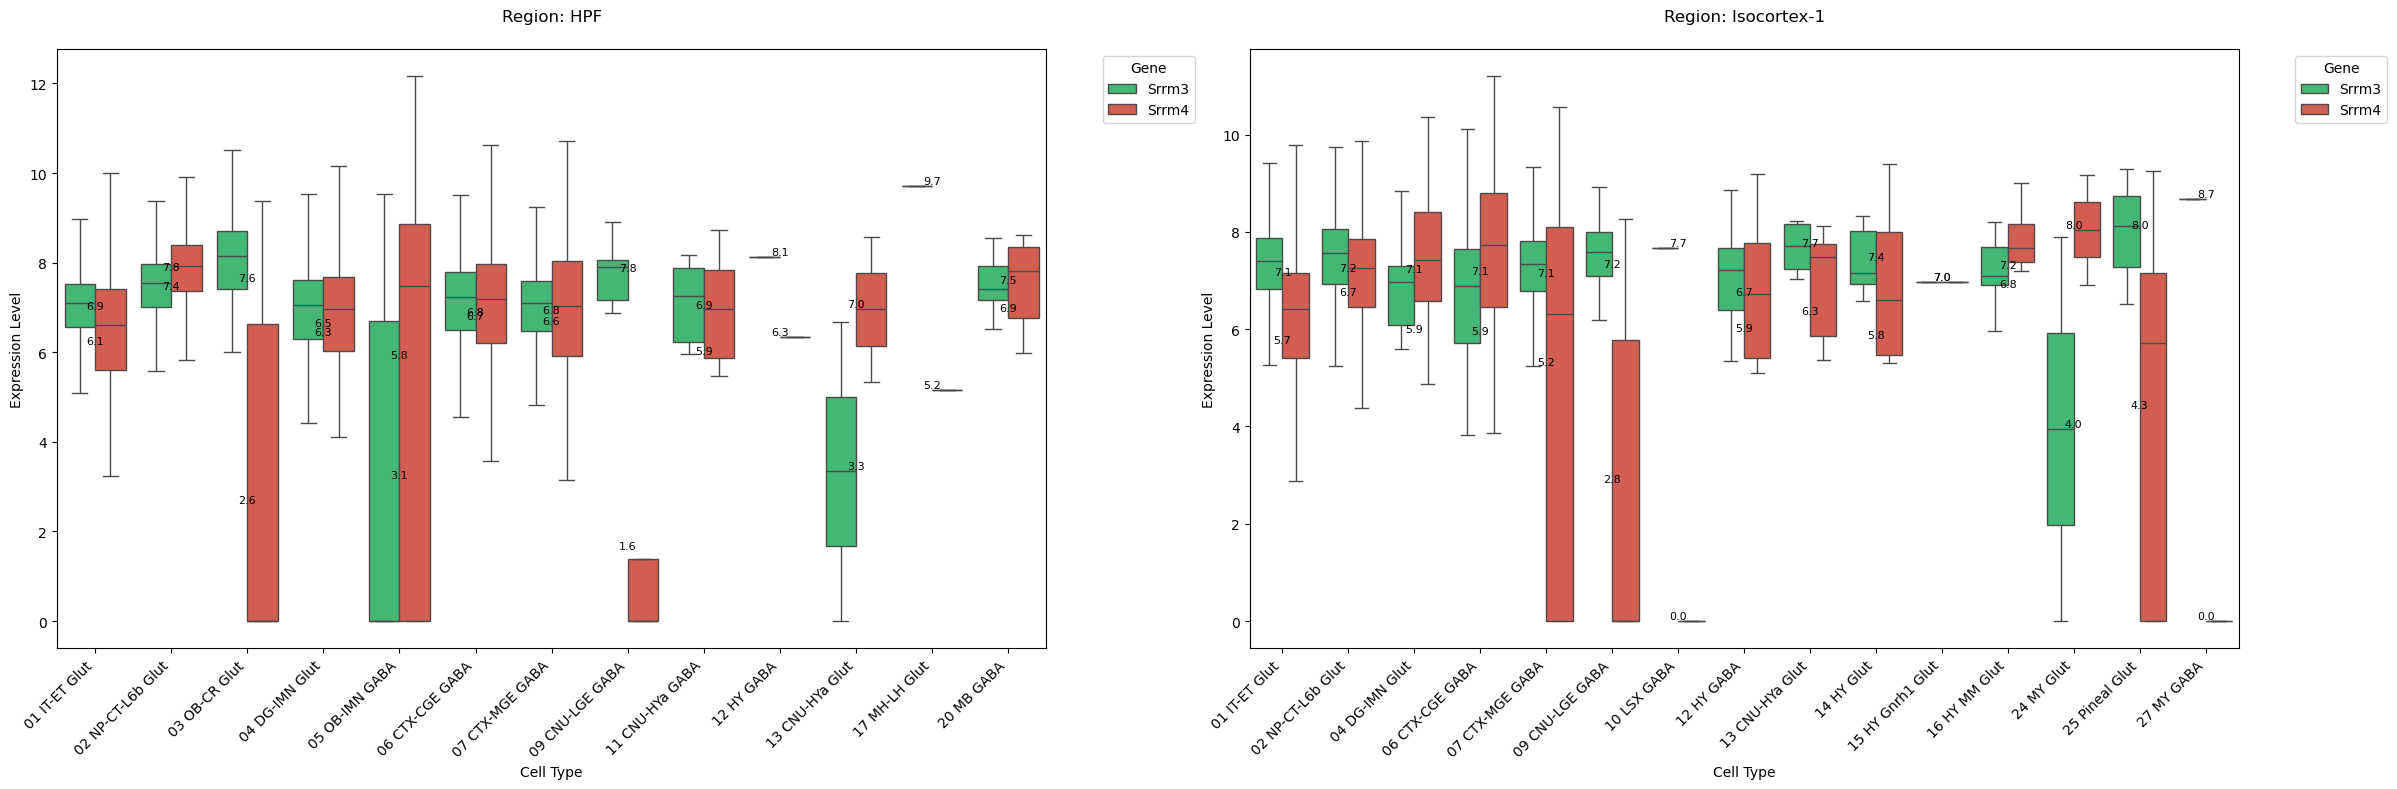

In [52]:
# Create visualizations
print("\nCreating region-specific box plots...")
fig, axes = plot_region_gene_comparison(
    expression_data,
    metadata,
    genes=['Srrm3', 'Srrm4'],
    group_by='class_label',
    figsize=(12, 8),
    top_n=10  # Show top 10 groups by expression
)
plt.show()

In [54]:
def plot_region_gene_comparison_cleaned(expression_data: pd.DataFrame, 
                              metadata: pd.DataFrame,
                              genes: List[str],
                              group_by: str,
                              figsize: Tuple[int, int] = (15, 10),
                              top_n: int = 15,
                              min_expr_threshold: float = 0.1):  # Added threshold parameter
    """
    Create separate plots for each brain region with side-by-side gene comparisons
    using violin plots and expression statistics
    """
    # Prepare the data (same as before)
    plot_data = pd.DataFrame({
        'Expression': pd.concat([expression_data[gene] for gene in genes]),
        'Gene': np.repeat(genes, len(expression_data)),
        'Group': pd.concat([metadata[group_by] for _ in genes]),
        'Region': pd.concat([expression_data['region'] for _ in genes])
    })
    
    # Get unique regions and setup subplots (same as before)
    regions = sorted(plot_data['Region'].unique())
    n_regions = len(regions)
    n_cols = 2
    n_rows = (n_regions + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0]*n_cols, figsize[1]*n_rows))
    if n_regions == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Plot for each region
    for idx, region in enumerate(regions):
        if idx < len(axes):
            ax = axes[idx]
            region_data = plot_data[plot_data['Region'] == region]
            
            # Calculate mean expression and % expressing cells per group and gene
            stats = []
            for group in region_data['Group'].unique():
                for gene in genes:
                    group_gene_data = region_data[
                        (region_data['Group'] == group) & 
                        (region_data['Gene'] == gene)
                    ]
                    
                    # Calculate statistics
                    total_cells = len(group_gene_data)
                    expressing_cells = len(group_gene_data[group_gene_data['Expression'] > min_expr_threshold])
                    mean_expr = group_gene_data['Expression'].mean()
                    
                    stats.append({
                        'Group': group,
                        'Gene': gene,
                        'Mean': mean_expr,
                        'Pct_expressing': (expressing_cells / total_cells) * 100
                    })
            
            stats_df = pd.DataFrame(stats)
            
            # Get top N groups based on either mean expression or % expressing
            top_groups_per_gene = []
            for gene in genes:
                gene_stats = stats_df[stats_df['Gene'] == gene]
                # You can change this to sort by 'Pct_expressing' instead
                top_for_gene = gene_stats.nlargest(top_n, 'Mean')['Group']
                top_groups_per_gene.extend(top_for_gene)
            
            top_groups = pd.Index(sorted(set(top_groups_per_gene)))
            region_data_filtered = region_data[region_data['Group'].isin(top_groups)]
            
            # Create violin plot
            sns.violinplot(data=region_data_filtered,
                          x='Group',
                          y='Expression',
                          hue='Gene',
                          order=top_groups,
                          palette=['#2ecc71', '#e74c3c'],
                          cut=0,  # Show the full range
                          scale='width',  # Scale each violin to same width
                          inner='box',  # Show box plot inside violin
                          ax=ax)
            
            # Customize the plot
            ax.set_title(f'Region: {region}', fontsize=12, pad=20)
            ax.set_xlabel('Cell Type', fontsize=10)
            ax.set_ylabel('Expression Level', fontsize=10)
            
            # Rotate x-axis labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            
            # Add expression statistics above each violin
            for i, group in enumerate(top_groups):
                for j, gene in enumerate(genes):
                    stats_row = stats_df[
                        (stats_df['Group'] == group) & 
                        (stats_df['Gene'] == gene)
                    ].iloc[0]
                    
                    # Position text above each violin
                    y_pos = region_data_filtered[
                        (region_data_filtered['Group'] == group) & 
                        (region_data_filtered['Gene'] == gene)
                    ]['Expression'].max()
                    
                    # Add mean and % expressing cells
                    ax.text(i, y_pos,
                           f'μ={stats_row["Mean"]:.1f}\n{stats_row["Pct_expressing"]:.0f}%',
                           ha='center', va='bottom', fontsize=8)
            
            # Adjust legend
            ax.legend(title='Gene', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Remove empty subplots if any
    for idx in range(len(regions), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    
    return fig, axes

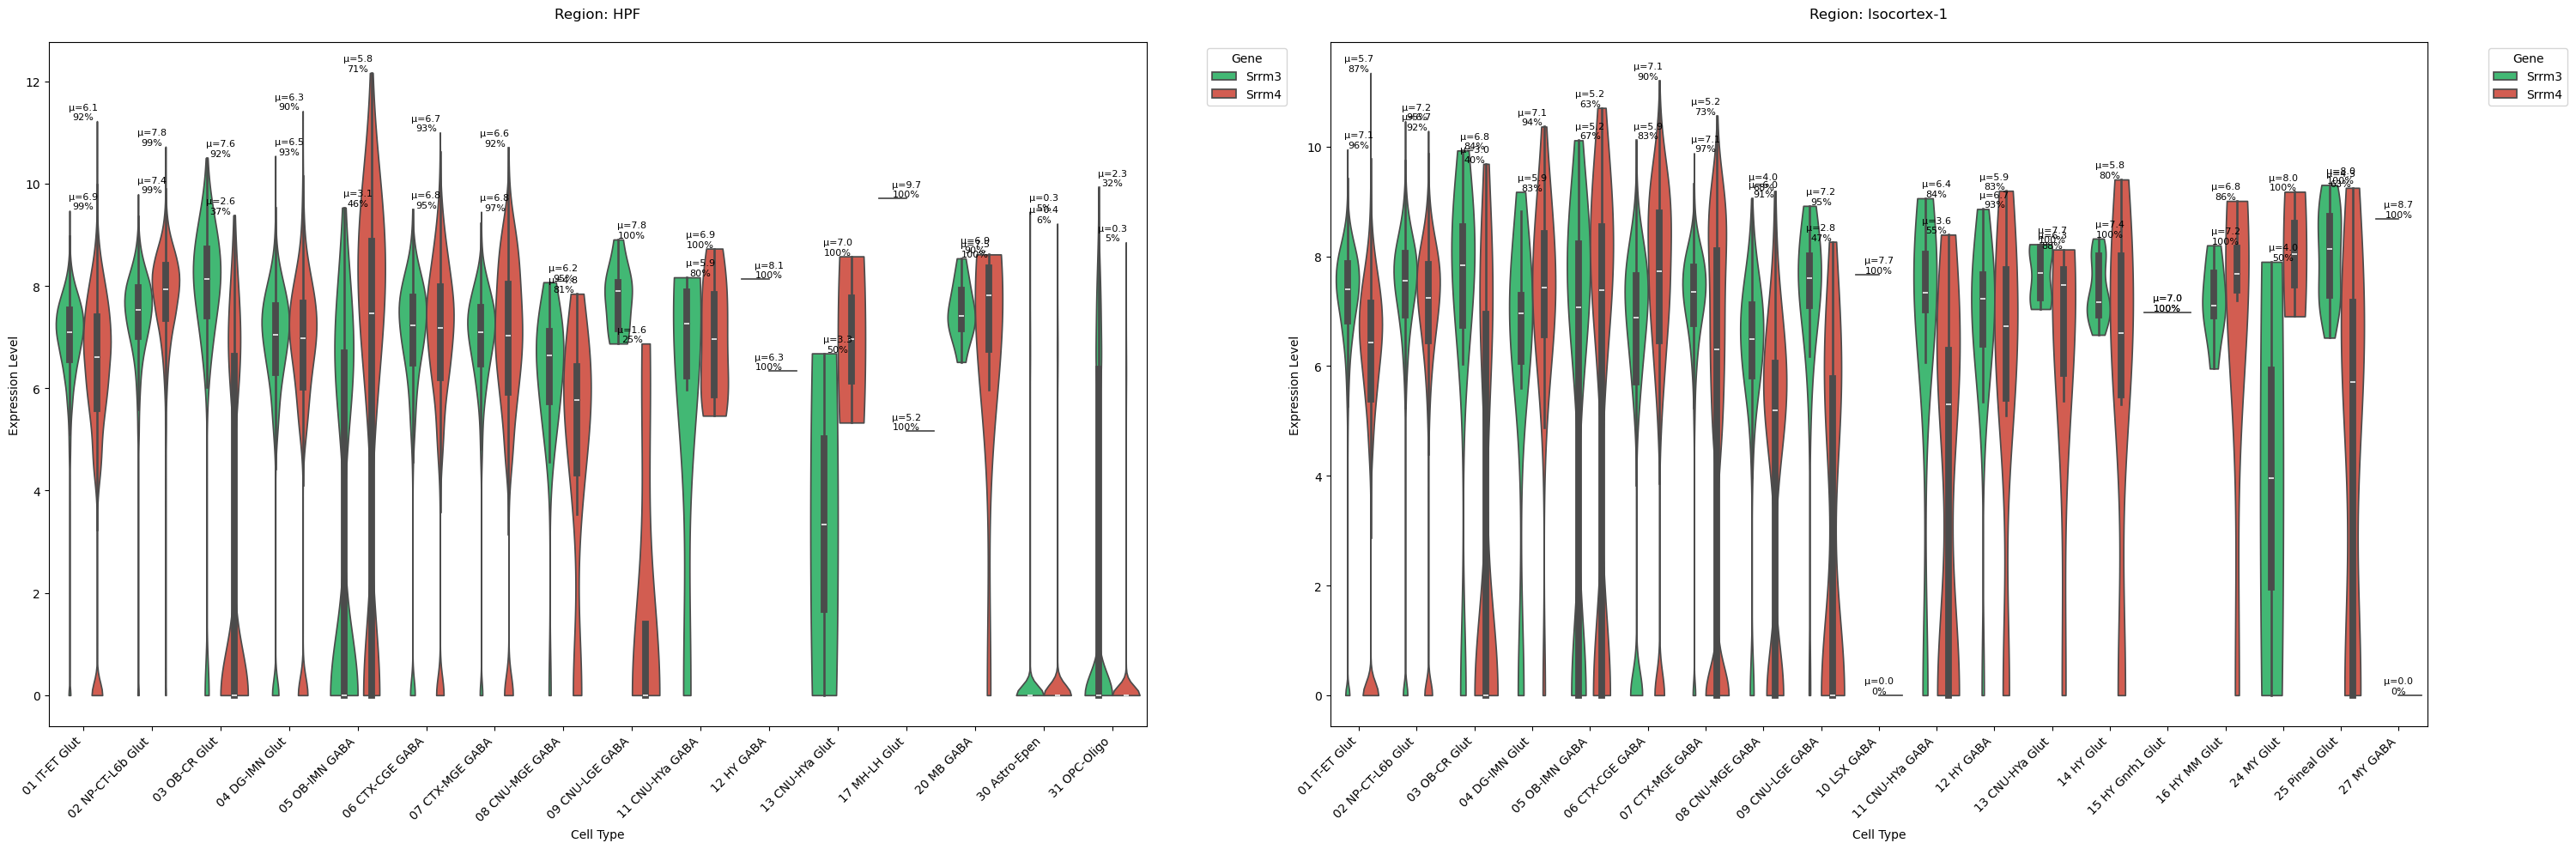

In [57]:
fig, axes = plot_region_gene_comparison_cleaned(
    expression_data,
    metadata,
    genes=['Srrm3', 'Srrm4'],
    group_by='class_label',
    min_expr_threshold=0.1
)

In [59]:
expression_data.head(5)

gene_symbol,Srrm4,Srrm3,region,dataset
TTCGGTCTCTTCCCAG-398_C01,7.899233,7.522533,HPF,WMB-10Xv3
AACCTTTTCCAATGCA-445_B05,0.000000,7.243039,HPF,WMB-10Xv3
TCCTCTTTCGCCAGAC-445_B05,6.970260,6.970260,HPF,WMB-10Xv3
ATTCACTTCAAACCTG-424_A02,6.079710,7.069005,HPF,WMB-10Xv3
CTGAGGCCAGGTTACT-410_B05,5.945732,7.253547,HPF,WMB-10Xv3


In [60]:
sample_df = pd.DataFrame({
        'Expression': pd.concat([expression_data[gene] for gene in genes]),
        'Gene': np.repeat(genes, len(expression_data)),
        'Group': pd.concat([metadata['class_label'] for _ in genes]),
        'Region': pd.concat([expression_data['region'] for _ in genes])
    })

sample_df.head(5)

,Expression,Gene,Group,Region
TTCGGTCTCTTCCCAG-398_C01,7.522533,Srrm3,01 IT-ET Glut,HPF
AACCTTTTCCAATGCA-445_B05,7.243039,Srrm3,01 IT-ET Glut,HPF
TCCTCTTTCGCCAGAC-445_B05,6.970260,Srrm3,01 IT-ET Glut,HPF
ATTCACTTCAAACCTG-424_A02,7.069005,Srrm3,31 OPC-Oligo,HPF
CTGAGGCCAGGTTACT-410_B05,7.253547,Srrm3,01 IT-ET Glut,HPF


In [62]:
sample_df[(sample_df.Region == 'HPF') & (sample_df.Group == '12 HY GABA')].head(5)


,Expression,Gene,Group,Region
GGTTGTATCGAGATGG-447_A06,8.131439,Srrm3,12 HY GABA,HPF
GGTTGTATCGAGATGG-447_A06,6.336889,Srrm4,12 HY GABA,HPF



Creating region-specific box plots...
Statistical Summary:


Region: Isocortex-1

Chol:
  Srrm3: mean=7.76, median=7.76, n=2
  Srrm4: mean=6.97, median=6.97, n=2

Glut:
  Srrm3: mean=7.10, median=7.45, n=179732
  Srrm4: mean=5.99, median=6.69, n=179732

Glut-GABA:
  Srrm3: mean=5.46, median=6.05, n=230
  Srrm4: mean=7.10, median=7.31, n=230

GABA:
  Srrm3: mean=6.47, median=7.18, n=26553
  Srrm4: mean=6.07, median=7.11, n=26553

Hist:
  Srrm3: mean=6.33, median=6.33, n=1
  Srrm4: mean=5.92, median=5.92, n=1

Nora:
  Srrm3: mean=0.00, median=0.00, n=1
  Srrm4: mean=9.18, median=9.18, n=1

GABA-Glyc:
  Srrm3: mean=8.69, median=8.69, n=1
  Srrm4: mean=0.00, median=0.00, n=1

Dopa:
  Srrm3: mean=6.80, median=8.03, n=13
  Srrm4: mean=1.12, median=0.00, n=13



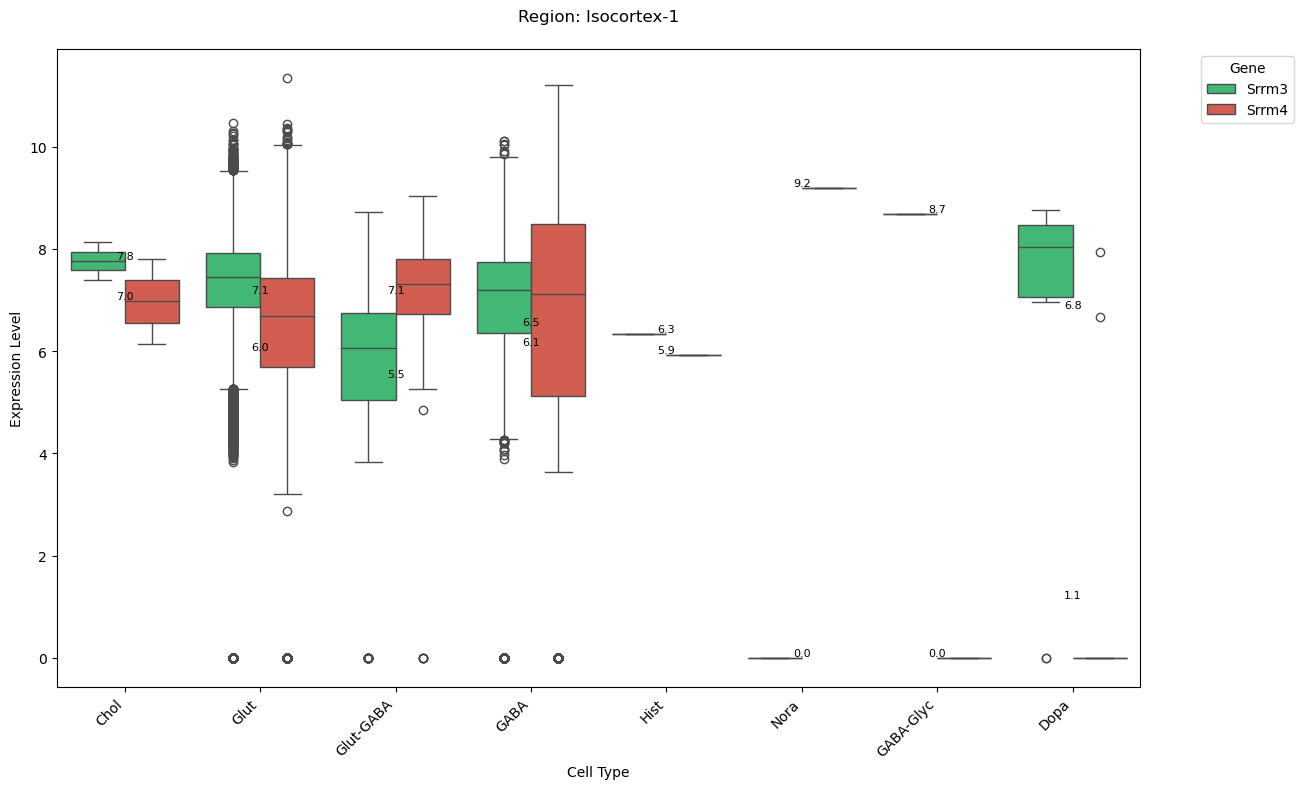

In [42]:
# Create visualizations
print("\nCreating region-specific box plots...")
fig, axes = plot_region_gene_comparison(
    expression_data,
    metadata,
    genes=['Srrm3', 'Srrm4'],
    group_by='neurotransmitter_label',
    figsize=(12, 8),
    top_n=10 # Show top 10 groups by expression
)
plt.show()

In [16]:
print("\nCreating dimension reduction plots...")
fig, _ = create_dimension_reduction_plot(
    expression_data,
    metadata,
    method='umap',
    color_by=['class_label', 'neurotransmitter_label', 'region'],
    genes=genes
)
plt.show()